In [1]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 35.6 MB/s 


In [2]:
# Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd # Pandas to create small dataframes 
import numpy as np
import datetime # Convert to unix time
import time # Convert to unix time
# If numpy is not installed already : pip3 install numpy
import numpy as np # Do aritmetic operations on arrays
# Matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns # Plots
from matplotlib import rcParams # Size of plots  
import math
import pickle
import os
# To install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from scipy.stats import randint as sp_randint, sp_randfloat
from xgboost import XGBClassifier
from pandas import read_hdf

import tensorflow
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph.utils import plot_history

from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_path = "gdrive/My Drive/Major Project/"

In [5]:
df_train = pd.read_csv(data_path+"pos_train_91_2.csv")

In [6]:
df_train.head()

,Unnamed: 0,src,dest,link
0,329593,14843,53045,1
1,502348,65366,38273,1
2,269592,1862,24370,1
3,288269,11946,50132,1
4,499295,59808,69735,1


In [7]:
train_graph = nx.from_pandas_edgelist(df_train, source='src', target='dest', create_using=nx.MultiDiGraph())

In [8]:
G = StellarGraph.from_networkx(train_graph)

In [ ]:
generator = AdjacencyPowerGenerator(G, num_powers = 3)

In [ ]:
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=64,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

In [ ]:
model = Model(inputs = x_in, outputs = x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-2))

In [ ]:
epochs = 9
batch_size = 100
train_gen = generator.flow(batch_size=batch_size)
history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size)
)

Epoch 1/9
758/758 [==============================] - 624s 819ms/step - loss: 5263665.0000
Epoch 2/9
758/758 [==============================] - 605s 798ms/step - loss: 295608.4062
Epoch 3/9
758/758 [==============================] - 603s 796ms/step - loss: 40323.2227
Epoch 4/9
758/758 [==============================] - 602s 794ms/step - loss: 35037.5078
Epoch 5/9
758/758 [==============================] - 600s 792ms/step - loss: 33024.3125
Epoch 6/9
758/758 [==============================] - 601s 793ms/step - loss: 31628.3828
Epoch 7/9
758/758 [==============================] - 603s 796ms/step - loss: 30915.8438
Epoch 8/9
758/758 [==============================] - 604s 796ms/step - loss: 30936.8125
Epoch 9/9
758/758 [==============================] - 604s 796ms/step - loss: 32338.4121


In [ ]:
embeddings = wys.embeddings()

In [ ]:
emb_file = open(data_path+"wys_embeddings_91_2.pkl", "wb")
pickle.dump(embeddings, emb_file)
emb_file.close()

In [9]:
emb_file = open(data_path+"wys_embeddings_91_2.pkl", "rb")
embeddings = pickle.load(emb_file)
emb_file.close()
embeddings.shape

(75879, 64)

In [10]:
nodes = list(G.nodes())
nodes[:5]

[14843, 53045, 65366, 38273, 1862]

In [11]:
emb_dict = {}
for i, node in enumerate(nodes):
  emb_dict[node] = np.array(embeddings[i].reshape(1,64))

In [12]:
combined_tr = pd.read_csv(data_path+"train_91_2.csv", index_col = 0)
print(combined_tr.shape)
combined_tr.head()

(902613, 3)


,src,dest,link
26102,1972,8899,0
188152,9098,17151,0
394436,19771,46179,0
507726,74448,385,1
498414,58263,69516,1


In [13]:
# get training embeddings
train_emb = []
for i, row in tqdm(combined_tr.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  train_emb.append(comb_emb[0])
train_emb = np.array(train_emb)

0it [00:00, ?it/s]

In [14]:
train_y = combined_tr['link']
len(train_y)

902613

In [15]:
combined_test = pd.read_csv(data_path+"test_91_2.csv", index_col = 0)
combined_test.head()

,src,dest,link
381519,21371,15072,1
312318,10950,60275,0
493058,67682,39756,0
465962,16581,15980,1
482102,32277,23293,1


In [16]:
# get test embeddings
test_emb = []
for i, row in tqdm(combined_test.iterrows()):
  comb_emb = (emb_dict[row['src']]) * (emb_dict[row['dest']])
  test_emb.append(comb_emb[0])

print(len(test_emb), len(test_emb[0]))
test_emb = np.array(test_emb)
print(test_emb.shape)
test_y = combined_test['link'] 

0it [00:00, ?it/s]

106224 64
(106224, 64)


In [21]:
#reading
df_final_train = read_hdf(data_path + 'fea_sample/storage_sample_stage4_2.h5', 'train_df',mode='r')
df_final_test = read_hdf(data_path + 'fea_sample/storage_sample_stage4_2.h5', 'test_df',mode='r')

In [22]:
df_final_train.columns

Index(['src', 'dest', 'link', 'jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'],
      dtype='object')

In [23]:
df_final_train.shape

(902613, 59)

In [24]:
y_train = df_final_train.link
y_test = df_final_test.link

In [25]:
df_final_train.drop(['src', 'dest','link'],axis=1,inplace=True)
df_final_test.drop(['src', 'dest','link'],axis=1,inplace=True)

In [ ]:
# WYS only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

In [ ]:
# WYS only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9097348691970156 test Score 0.9095668082562742


In [ ]:
# WYS only
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(train_emb, train_y)
train_sc = f1_score(train_y,clf.predict(train_emb))
test_sc = f1_score(test_y,clf.predict(test_emb))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9015952100785296 test Score 0.9095510663195421


In [ ]:
# Heuristic only
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)f
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.983029655226594 test Score 0.9458179808400884


In [ ]:
# Heuristic only
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9771341261464953 test Score 0.9465713006860139


In [ ]:
# Heuristic only
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9832426574663836 test Score 0.9469947114279144


In [26]:
df_final_train = np.hstack((df_final_train, train_emb))
print(df_final_train.shape)
df_final_test = np.hstack((df_final_test, test_emb))
print(df_final_test.shape)

(902613, 120)
(106224, 120)


In [ ]:
print(type(train_y), type(y_train))
for i in range(len(y_train.values)):
  if train_y.values[i] != y_train.values[i]: print(i)

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [ ]:
# Heuristic + WYS
clf = XGBClassifier(max_depth=7, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9834132136677243 test Score 0.9462615101289135


In [ ]:
# Heuristic + WYS
clf = RandomForestClassifier(max_depth=12, n_estimators=100, n_jobs=-1,
              random_state=25)
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9753325590107826 test Score 0.9463148482691922


In [27]:
# Heuristic + WYS
clf = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, 
                     objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, 
                     subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, importance_type='split')
clf.fit(df_final_train,y_train)
train_sc = f1_score(y_train,clf.predict(df_final_train))
test_sc = f1_score(y_test,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9822621037363696 test Score 0.9534651743797644


In [ ]:
%%time
clf = LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=160, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9772666452875672 test Score 0.9505805462246238
CPU times: user 3min 22s, sys: 401 ms, total: 3min 23s
Wall time: 1min 45s


In [ ]:
param_dist = {
    "boosting_type": ['gbdt', 'dart', 'goss', 'rf'],
    "learning_rate": [0.001, 0.01, 0.05, 0.5, 1],
    "num_leaves": [15, 31, 63]
}

clf = LGBMClassifier(n_estimators = 160, max_depth = 15, random_state=25, n_jobs=-1)

lgb_random = GridSearchCV(clf, param_grid=param_dist, cv=3, scoring='f1', return_train_score = True, verbose = 10)

lgb_random.fit(df_final_train,train_y)
print('mean test scores',lgb_random.cv_results_['mean_test_score'])
print('mean train scores',lgb_random.cv_results_['mean_train_score'])
print(lgb_random.best_estimator_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV 1/3; 1/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=15.....
[CV 1/3; 1/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=15;, score=(train=0.971, test=0.971) total time=  58.2s
[CV 2/3; 1/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=15.....
[CV 2/3; 1/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=15;, score=(train=0.971, test=0.971) total time=  56.7s
[CV 3/3; 1/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=15.....
[CV 3/3; 1/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=15;, score=(train=0.971, test=0.970) total time=  56.9s
[CV 1/3; 2/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=31.....
[CV 1/3; 2/60] END boosting_type=gbdt, learning_rate=0.001, num_leaves=31;, score=(train=0.975, test=0.976) total time= 1.2min
[CV 2/3; 2/60] START boosting_type=gbdt, learning_rate=0.001, num_leaves=31.....
[CV 2/3; 2/60] END boosti

In [ ]:
%%time
clf = LGBMClassifier(learning_rate=0.05, max_depth=15, n_estimators=160, num_leaves = 63, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9846376311704851 test Score 0.9462624997698016
CPU times: user 4min 34s, sys: 566 ms, total: 4min 34s
Wall time: 2min 34s


In [ ]:
%%time
clf = LGBMClassifier(boosting_type = 'goss', learning_rate=0.01, max_depth=15, n_estimators=160, num_leaves = 63, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9793682551767486 test Score 0.9475895986640487
CPU times: user 3min 51s, sys: 611 ms, total: 3min 52s
Wall time: 2min 3s


In [ ]:
%%time
clf = LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=160, random_state=25)
clf.fit(df_final_train, train_y)
train_sc = f1_score(train_y,clf.predict(df_final_train))
test_sc = f1_score(test_y,clf.predict(df_final_test))
print('Train Score',train_sc,'test Score',test_sc)

Train Score 0.9772666452875672 test Score 0.9505805462246238
CPU times: user 3min 22s, sys: 429 ms, total: 3min 22s
Wall time: 1min 45s


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

Train confusion_matrix


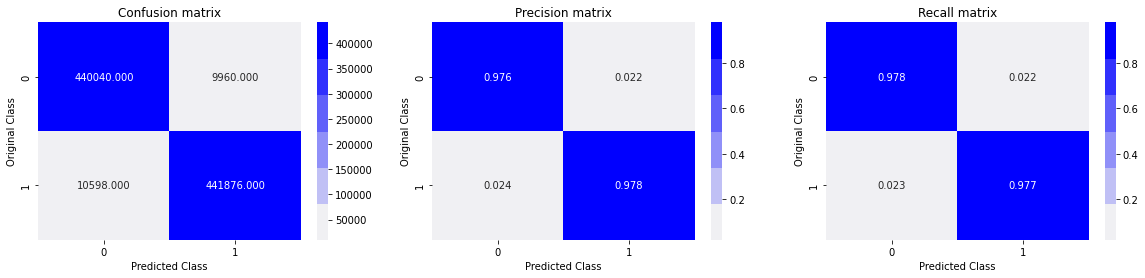

Test confusion_matrix


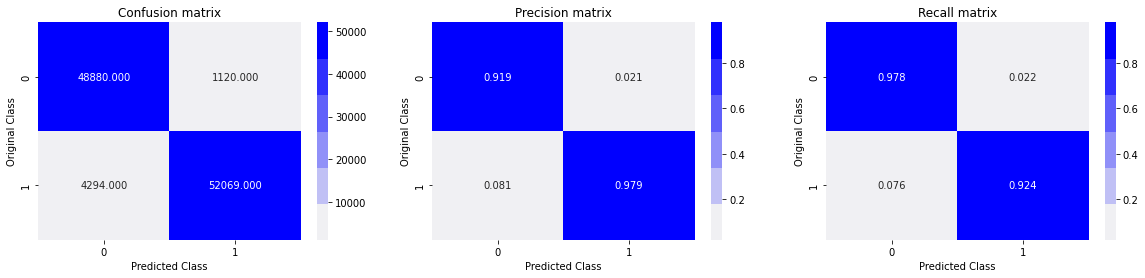

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

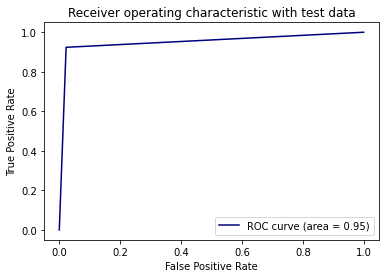

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

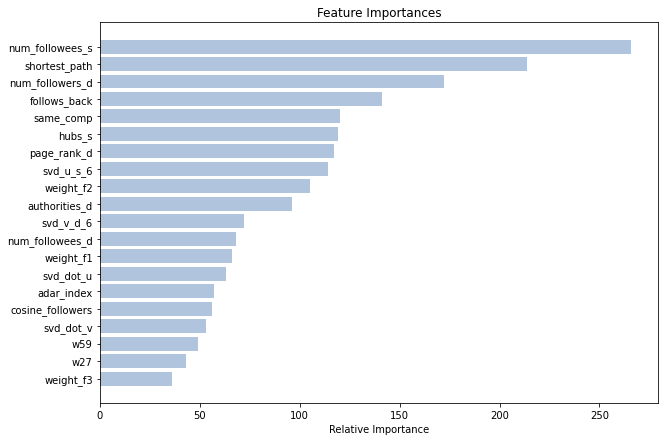

In [39]:
features = ['jaccard_followers', 'jaccard_followees',
       'cosine_followers', 'cosine_followees', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'adar_index', 'follows_back',
       'same_comp', 'shortest_path', 'weight_in', 'weight_out', 'weight_f1',
       'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d',
       'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_u', 'svd_dot_v', 'pref_attach_er', 'pref_attach_ee'] + ['w' + str(i) for i in range(64)]

importances = clf.feature_importances_
indices = (np.argsort(importances))[-20:]
plt.figure(figsize=(10,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightsteelblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()